Allows for multiple policies to be compared at once

In [2]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet
from gpudrive.agents.core import merge_actions,create_policy_masks
from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config 
import sys
import imageio
import numpy as np
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

sys.path.append(project_root+'/examples/experimental')

from eval_utils import multi_policy_rollout,compute_metrics  








In [3]:
def create_policy_masks(env, num_sim_agents=2, num_worlds=10):
    policy_mask = torch.zeros_like(env.cont_agent_mask, dtype=torch.int)
    agent_indices = env.cont_agent_mask.nonzero(as_tuple=True)

    for i, (world_idx, agent_idx) in enumerate(zip(*agent_indices)):
        policy_mask[world_idx, agent_idx] = (i % num_sim_agents) + 1

    policy_masks = {f'pi_{int(policy.item())}': torch.zeros_like(env.cont_agent_mask, dtype=torch.bool,device=device) 
                    for policy in policy_mask.unique() if policy.item() != 0}

    for p in range(1, num_sim_agents + 1):
        policy_masks[f'pi_{p}'] = (policy_mask == p).reshape(num_worlds, -1)

    return policy_masks


In [4]:


config = load_config(project_root+"/examples/experimental/config/eval_config")

VIDEO_PATH = "videos"

max_agents = config.max_controlled_agents
NUM_WORLDS = 2
device = "cpu" # cpu just because we're in a notebook
NUM_SIM_AGENTS = 2
FPS = 5

sim_agent1 = NeuralNet.from_pretrained("daphne-cornelisse/policy_S10_000_02_27")
sim_agent2 = NeuralNet.from_pretrained("daphne-cornelisse/policy_S1000_02_27")

# Some other info
card = ModelCard.load("daphne-cornelisse/policy_S10_000_02_27")


VIDEO_PATH = "videos"

max_agents = config.max_controlled_agents
NUM_WORLDS = 2
device = "cpu" # cpu just because we're in a notebook
NUM_SIM_AGENTS = 2
FPS = 5

sim_agent1 = NeuralNet.from_pretrained("daphne-cornelisse/policy_S10_000_02_27")
sim_agent2 = NeuralNet.from_pretrained("daphne-cornelisse/policy_S1000_02_27")

# Some other info
card = ModelCard.load("daphne-cornelisse/policy_S10_000_02_27")

In [5]:
#/home/charliemolony/Desktop/gpudrive/data/processed/examples
# Create data loader
train_loader = SceneDataLoader(
    root=project_root+'/data/processed/examples',
    batch_size=NUM_WORLDS,
    dataset_size=100,
    sample_with_replacement=False,
)

# Set params
env_config = dataclasses.replace(
    EnvConfig(),
    ego_state=config.ego_state,
    road_map_obs=config.road_map_obs,
    partner_obs=config.partner_obs,
    reward_type=config.reward_type,
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
)



env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=config.max_controlled_agents,
    device=device,
)

In [6]:
next_obs = env.reset()


control_mask = env.cont_agent_mask

policy_mask = create_policy_masks(env, 2,NUM_WORLDS)

policies_set = {'pi_1': (sim_agent1,policy_mask['pi_1']),
                'pi_2': (sim_agent2, policy_mask['pi_2'])
                } 
        


metrics,frames=multi_policy_rollout(
env,
policies_set, 
device,
deterministic=False,
render_sim_state = True,
render_every_n_steps= 5
)






env.close()


t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 15
t: 16
t: 17
t: 18
t: 19
t: 20
t: 21
t: 22
t: 23
t: 24
t: 25
t: 26
t: 27
t: 28
t: 29
t: 30
t: 31
t: 32
t: 33
t: 34
t: 35
t: 36
t: 37
t: 38
t: 39
t: 40
t: 41
t: 42
t: 43
t: 44
t: 45
t: 46
t: 47
t: 48
t: 49
t: 50
t: 51
t: 52
t: 53
t: 54


0,1

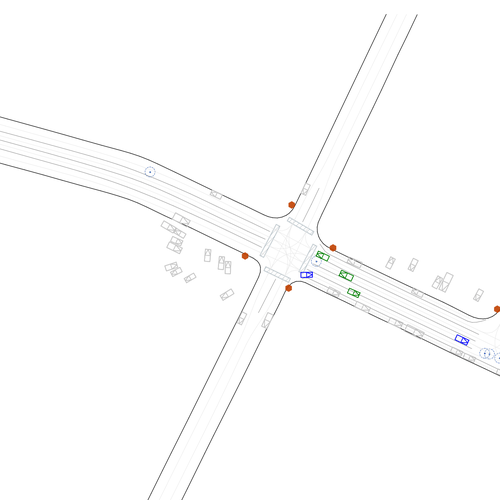
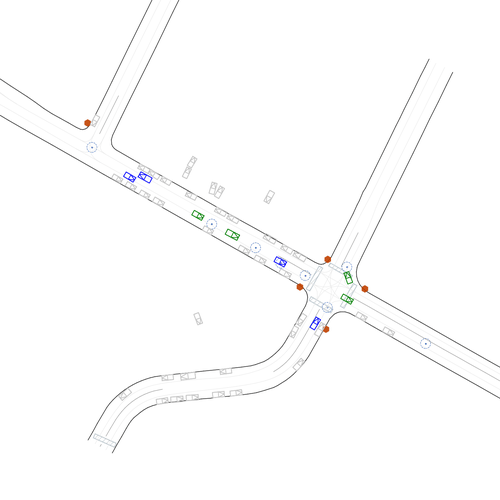

In [8]:


mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')